In [129]:
import util
from importlib import reload
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import timezone

# reset util library in case of updates

util = reload(util)

In [103]:
ochl = util.get_layer1_ochl()
ret = util.get_layer1_returns(0)

File not found. Fetching from database.


In [105]:
len(ret.columns)

289

In [106]:
in_sample_ret = ret.loc['2019-01-01':'2023-12-31']
out_of_sample_ret = ret.loc['2024-01-01':]

In [107]:
def equal_weighting(ret):
    '''equal weighting of returns'''
    ret = ret.div(ret.abs().sum(axis=1),axis=0)
    return ret.fillna(0)

def zscore_reversal_long(ret, enter_lookback=12, exit_lookback=15, enter_zscore = -3, exit_zscore = 1 ):
    """
    Generate long positions for momentum strategy based on zscore

    Parameters:
      ret : pandas.DataFrame
          DataFrame of asset returns (or prices) with a DateTime index and assets as columns.
      short_lookback : int, optional
          Lookback period for short-term high/low calculations.
      enter_lookback : int, optional
          Lookback period for the entry threshold (long-term high).
      exit_lookback : int, optional
          Lookback period for the exit threshold (long-term low).

    Returns:
    """
    long_enter_zscore= (ret-ret.rolling(window=enter_lookback, min_periods=1).mean()).divide(ret.rolling(window=enter_lookback, min_periods=1).std())
    long_exit_zscore  = (ret-ret.rolling(window=exit_lookback, min_periods=1).mean()).divide(ret.rolling(window=exit_lookback, min_periods=1).std())


    position = pd.DataFrame(
        np.where(long_enter_zscore <= enter_zscore, 1, np.where(long_exit_zscore > exit_zscore, 0, np.nan)),
        index=ret.index,
        columns=ret.columns
    )
    position = position.ffill().fillna(0)
    
    return position

signal = equal_weighting(zscore_reversal_long(out_of_sample_ret))

In [112]:
def get_positive_columns(df):
    result_df = df.apply(lambda row: row.index[row > 0].tolist(), axis=1)
    result_df = result_df.to_frame(name="positive_columns")  # Convert Series to DataFrame
    return result_df
get_positive_columns(signal.iloc[-1000:])

,positive_columns
date,
2025-01-24 06:00:00+00:00,[c4e]
2025-01-24 07:00:00+00:00,"[c4e, cacao]"
2025-01-24 08:00:00+00:00,"[c4e, epic, sha]"
2025-01-24 09:00:00+00:00,"[c4e, dentx, epic, sha, zth]"
2025-01-24 10:00:00+00:00,"[arthera, c4e, dentx, sha]"
...,...
2025-03-06 17:00:00+00:00,"[dentx, met]"
2025-03-06 18:00:00+00:00,"[cudos, dentx]"
2025-03-06 19:00:00+00:00,"[cudos, dentx, oxen]"


<Axes: xlabel='date'>

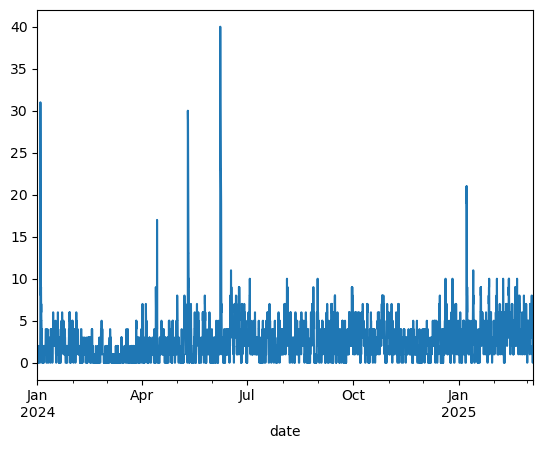

In [108]:
signal.map(lambda x: x > 0).sum(axis=1).plot()

Corr with BTC:  0.0059523549599358695
Average Turnover:  0.34055412590478384
Sharpe Ratio:  5.3152985701826205
Max Drawdown:  0.7447229916975218
Max Drawdown Duration:  1.3333333333333333  days


(0.34055412590478384,
 5.3152985701826205,
 0.7447229916975218,
 1.3333333333333333)

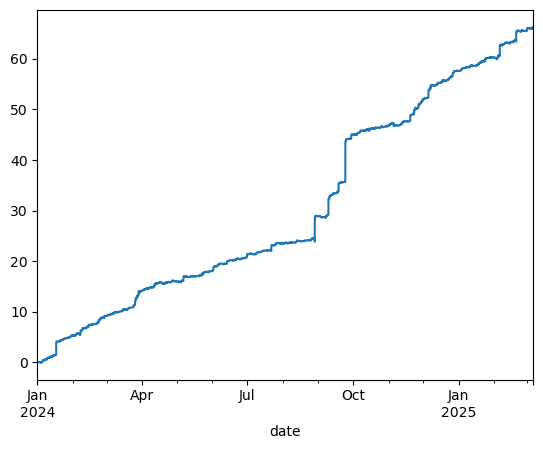

In [109]:
util.to_sharpe(signal, out_of_sample_ret, plot = True)